# Gesture Recognition

In [60]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os

import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [62]:
import tensorflow as tf
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
#tf.set_random_seed(30)

2.14.0


In [65]:
train_doc = np.random.permutation(open('train.csv').readlines())
val_doc = np.random.permutation(open('val.csv').readlines())
num_classes = 5  #number of softmax classes

In [66]:
curr_dt_time = datetime.datetime.now()
train_path = 'train'
val_path = 'val'
num_train_sequences = len(train_doc)
print('training  =', num_train_sequences)
num_val_sequences = len(val_doc)
print('validation  =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


Function to plot loss and accuracy

In [67]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Function to calculate steps

In [68]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

Function for callbacks

In [69]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]    

## Generator

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread("1.jpg")
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.imread("2.jpg")


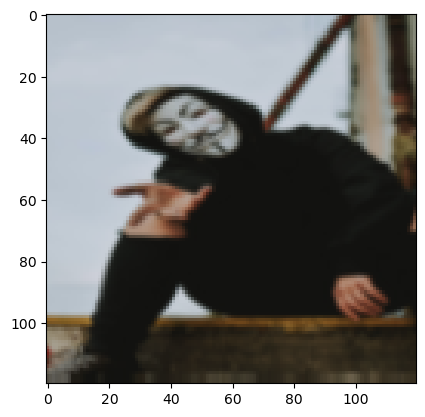

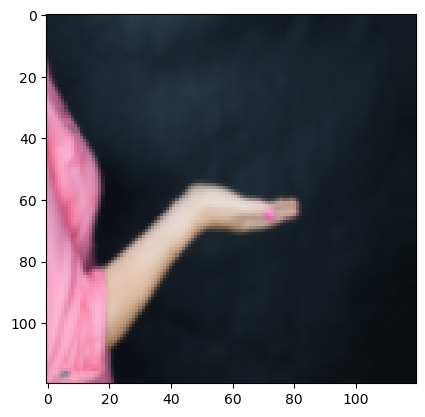

In [70]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imageio.imread("1.jpg")
#160 by 120
image2 = imageio.imread("2.jpg")
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes                    
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()
## Test code end

def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    #batch_data[folder,idx,:,:,0] = (image[...,0] - image[...,0].min())/(image[...,0].max() - image[...,0].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,1] = (image[...,1] - image[...,1].min())/(image[...,1].max() - image[...,1].min())#normalise and feed in the image
                    #batch_data[folder,idx,:,:,2] = (image[...,2] - image[...,2].min())/(image[...,2].max() - image[...,2].min())#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [71]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

### Conv3d Models

In [72]:
# Function to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)


In [73]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_35 (Activation)  (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_31 (Ba  (None, 30, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_20 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                            

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [74]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [75]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/2636822326.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
64/67 [===========================>..] - ETA: 16s - loss: 1.5109 - categorical_accuracy: 0.4484

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5205 - categorical_accuracy: 0.4495
Epoch 1: val_loss improved from inf to 5.11061, saving model to model_conv3D_1_2023-12-1221_57_21.433890/model-00001-1.52052-0.44947-5.11061-0.16000.h5
67/67 [==============================] - 395s 6s/step - loss: 1.5205 - categorical_accuracy: 0.4495 - val_loss: 5.1106 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2170 - categorical_accuracy: 0.5430
Epoch 2: val_loss improved from 5.11061 to 1.89836, saving model to model_conv3D_1_2023-12-1221_57_21.433890/model-00002-1.21704-0.54299-1.89836-0.31000.h5
67/67 [==============================] - 388s 6s/step - loss: 1.2170 - categorical_accuracy: 0.5430 - val_loss: 1.8984 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.0716 - categorical_accuracy: 0.6063
Epoch 3: val_loss did not improve from 1.89836
67/6

#### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [77]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 20, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_42 (Activation)  (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_37 (Ba  (None, 20, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_24 (MaxPooli  (None, 10, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints

In [78]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [79]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
64/67 [===========================>..] - ETA: 6s - loss: 1.5525 - categorical_accuracy: 0.4516

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5424 - categorical_accuracy: 0.4525
Epoch 1: val_loss improved from inf to 2.63401, saving model to model_conv3D_2_2023-12-1221_57_21.433890/model-00001-1.54238-0.45249-2.63401-0.21000.h5
67/67 [==============================] - 156s 2s/step - loss: 1.5424 - categorical_accuracy: 0.4525 - val_loss: 2.6340 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.2435 - categorical_accuracy: 0.5385
Epoch 2: val_loss did not improve from 2.63401
67/67 [==============================] - 155s 2s/step - loss: 1.2435 - categorical_accuracy: 0.5385 - val_loss: 2.9150 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9947 - categorical_accuracy: 0.6199
Epoch 3: val_loss did not improve from 2.63401
67/67 [==============================] - 155s 2s/step - loss: 0.9947 - categorical_accuracy: 0.6199 - val_loss: 3

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


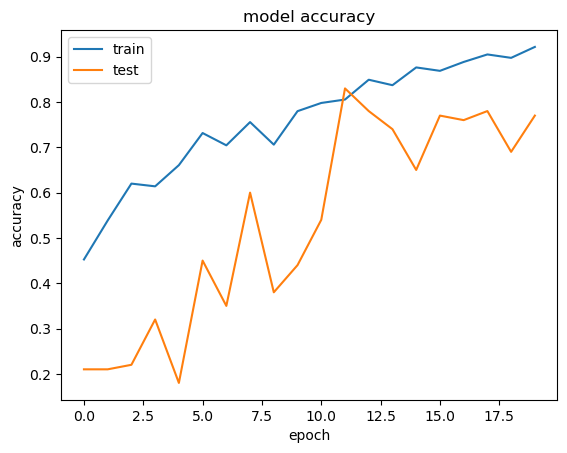

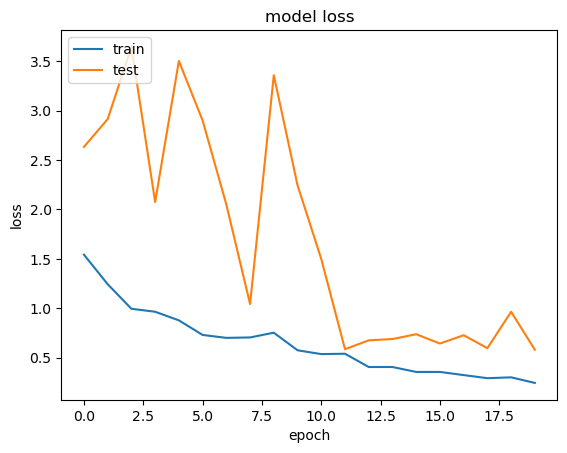

In [80]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [81]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 30, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_49 (Activation)  (None, 30, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization_43 (Ba  (None, 30, 160, 160, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_28 (MaxPooli  (None, 15, 80, 80, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_29 (Conv3D)          (None, 15, 80, 80, 32)   

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints

In [82]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [83]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
64/67 [===========================>..] - ETA: 19s - loss: 1.5834 - categorical_accuracy: 0.4328

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5784 - categorical_accuracy: 0.4359
Epoch 1: val_loss improved from inf to 4.24419, saving model to model_conv3D_3_2023-12-1221_57_21.433890/model-00001-1.57842-0.43590-4.24419-0.16000.h5
67/67 [==============================] - 454s 7s/step - loss: 1.5784 - categorical_accuracy: 0.4359 - val_loss: 4.2442 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0827 - categorical_accuracy: 0.5581
Epoch 2: val_loss did not improve from 4.24419
67/67 [==============================] - 446s 7s/step - loss: 1.0827 - categorical_accuracy: 0.5581 - val_loss: 5.1400 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9660 - categorical_accuracy: 0.6380
Epoch 3: val_loss did not improve from 4.24419
67/67 [==============================] - 442s 7s/step - loss: 0.9660 - categorical_accuracy: 0.6380 - val_loss: 6

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


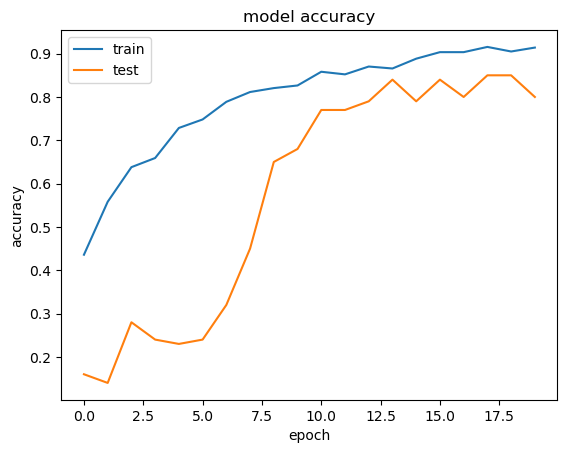

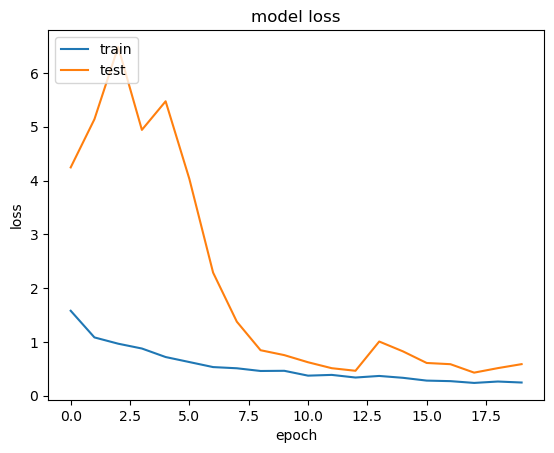

In [84]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [85]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 20, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation_56 (Activation)  (None, 20, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization_49 (Ba  (None, 20, 160, 160, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_32 (MaxPooli  (None, 10, 80, 80, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_33 (Conv3D)          (None, 10, 80, 80, 32)   

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [86]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [87]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
64/67 [===========================>..] - ETA: 12s - loss: 1.5597 - categorical_accuracy: 0.4328

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5720 - categorical_accuracy: 0.4299
Epoch 1: val_loss improved from inf to 10.33130, saving model to model_conv3D_4_2023-12-1221_57_21.433890/model-00001-1.57203-0.42986-10.33130-0.16000.h5
67/67 [==============================] - 285s 4s/step - loss: 1.5720 - categorical_accuracy: 0.4299 - val_loss: 10.3313 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.1386 - categorical_accuracy: 0.5747
Epoch 2: val_loss did not improve from 10.33130
67/67 [==============================] - 281s 4s/step - loss: 1.1386 - categorical_accuracy: 0.5747 - val_loss: 20.2366 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9789 - categorical_accuracy: 0.6244
Epoch 3: val_loss improved from 10.33130 to 2.20779, saving model to model_conv3D_4_2023-12-1221_57_21.433890/model-00003-0.97892-0.62443-2.20779-0.32000.h

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


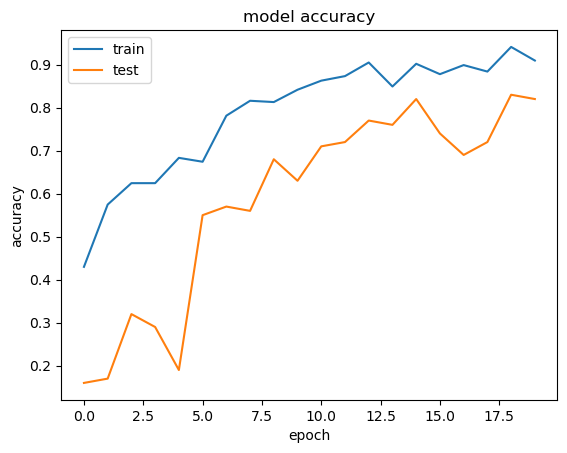

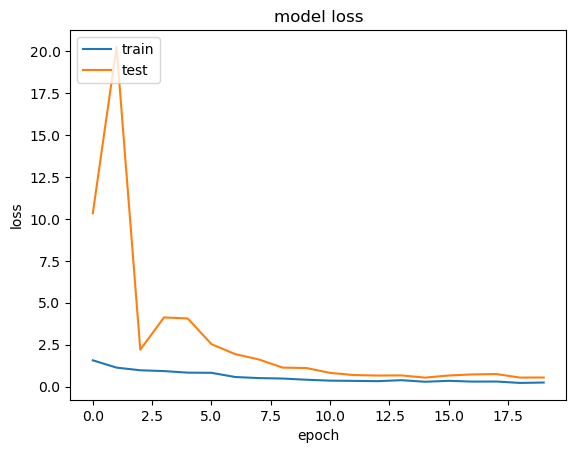

In [88]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer) + Random data transformations on training data set

In [89]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_63 (Activation)  (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_55 (Ba  (None, 30, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_36 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_37 (Conv3D)          (None, 15, 60, 60, 32)  

In [90]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [91]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
64/67 [===========================>..] - ETA: 10s - loss: 1.8073 - categorical_accuracy: 0.3844

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.7908 - categorical_accuracy: 0.3861
Epoch 1: val_loss improved from inf to 3.89411, saving model to model_conv3D_5_2023-12-1221_57_21.433890/model-00001-1.79076-0.38612-3.89411-0.25000.h5
67/67 [==============================] - 246s 4s/step - loss: 1.7908 - categorical_accuracy: 0.3861 - val_loss: 3.8941 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.2790 - categorical_accuracy: 0.5128
Epoch 2: val_loss did not improve from 3.89411
67/67 [==============================] - 244s 4s/step - loss: 1.2790 - categorical_accuracy: 0.5128 - val_loss: 5.7353 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.1744 - categorical_accuracy: 0.5701
Epoch 3: val_loss improved from 3.89411 to 3.24842, saving model to model_conv3D_5_2023-12-1221_57_21.433890/model-00003-1.17442-0.57014-3.24842-0.19000.h5
67/6

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


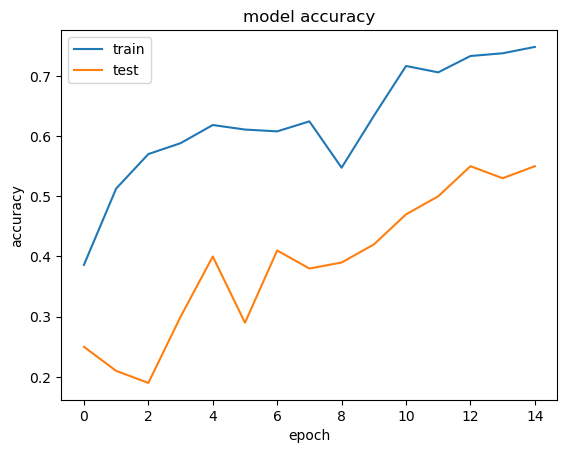

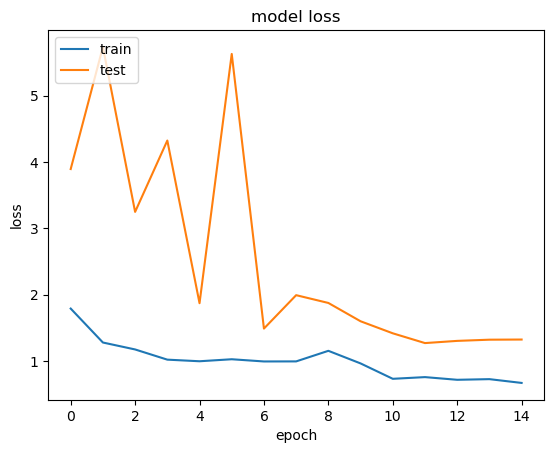

In [92]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video (8, 16, 32, 64 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [93]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (8, 16, 32, 64) 
model = conv3D(conv_filters, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 activation_70 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 batch_normalization_61 (Ba  (None, 30, 120, 120, 8)   32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_40 (MaxPooli  (None, 15, 60, 60, 8)     0         
 ng3D)                                                           
                                                                 
 conv3d_41 (Conv3D)          (None, 15, 60, 60, 16)    3472      
                                                                 
 activation_71 (Activation)  (None, 15, 60, 60, 16)  

In [94]:
callbacks_list = model_callbacks("model_conv3D_6")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [95]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
64/67 [===========================>..] - ETA: 6s - loss: 1.5040 - categorical_accuracy: 0.4531

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5062 - categorical_accuracy: 0.4585
Epoch 1: val_loss improved from inf to 4.54986, saving model to model_conv3D_6_2023-12-1221_57_21.433890/model-00001-1.50622-0.45852-4.54986-0.16000.h5
67/67 [==============================] - 155s 2s/step - loss: 1.5062 - categorical_accuracy: 0.4585 - val_loss: 4.5499 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.0520 - categorical_accuracy: 0.5807
Epoch 2: val_loss did not improve from 4.54986
67/67 [==============================] - 154s 2s/step - loss: 1.0520 - categorical_accuracy: 0.5807 - val_loss: 5.4745 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.8025 - categorical_accuracy: 0.6817
Epoch 3: val_loss did not improve from 4.54986
67/67 [==============================] - 155s 2s/step - loss: 0.8025 - categorical_accuracy: 0.6817 - val_loss: 6

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


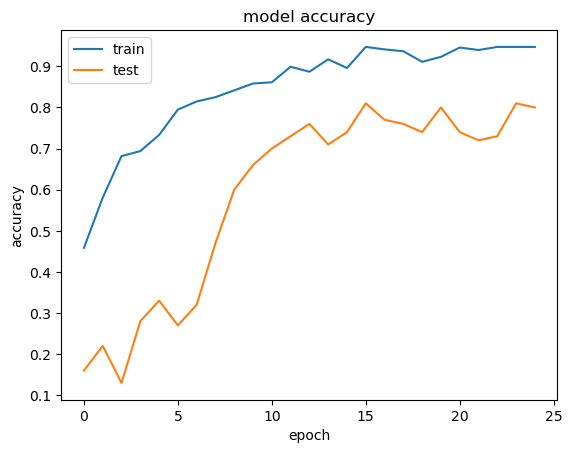

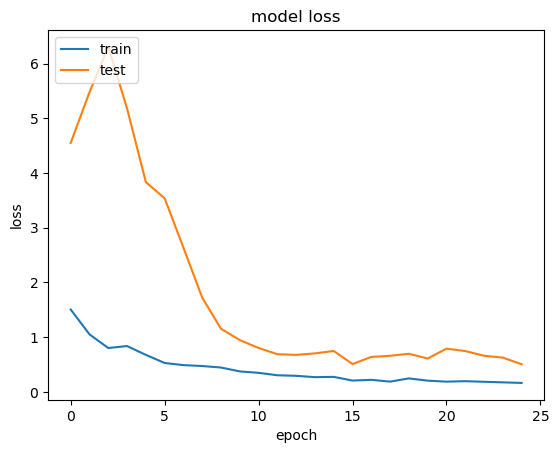

In [96]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 128 dense layer + 64 dense layer + image size 120 by 120)

In [97]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (16, 32, 64, 128)
dense_filters = (128, 64) 
model = conv3D(conv_filters=conv_filters, dense_nodes=dense_filters, dropout=0.2, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 30, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_77 (Activation)  (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_67 (Ba  (None, 30, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_44 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_45 (Conv3D)          (None, 15, 60, 60, 32)  

In [98]:
callbacks_list = model_callbacks("model_conv3D_7")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=False, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [99]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
64/67 [===========================>..] - ETA: 9s - loss: 1.5979 - categorical_accuracy: 0.3906 

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5991 - categorical_accuracy: 0.3922
Epoch 1: val_loss improved from inf to 1.71601, saving model to model_conv3D_7_2023-12-1221_57_21.433890/model-00001-1.59913-0.39216-1.71601-0.31000.h5
67/67 [==============================] - 236s 4s/step - loss: 1.5991 - categorical_accuracy: 0.3922 - val_loss: 1.7160 - val_categorical_accuracy: 0.3100 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2877 - categorical_accuracy: 0.4691
Epoch 2: val_loss did not improve from 1.71601
67/67 [==============================] - 235s 4s/step - loss: 1.2877 - categorical_accuracy: 0.4691 - val_loss: 2.2666 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.0030 - categorical_accuracy: 0.6094
Epoch 3: val_loss did not improve from 1.71601
67/67 [==============================] - 236s 4s/step - loss: 1.0030 - categorical_accuracy: 0.6094 - val_loss: 2

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


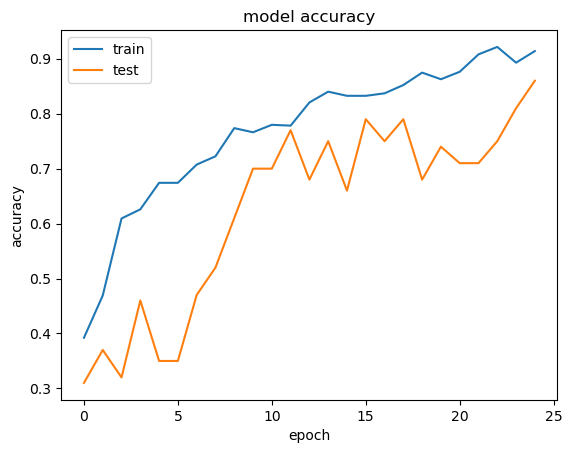

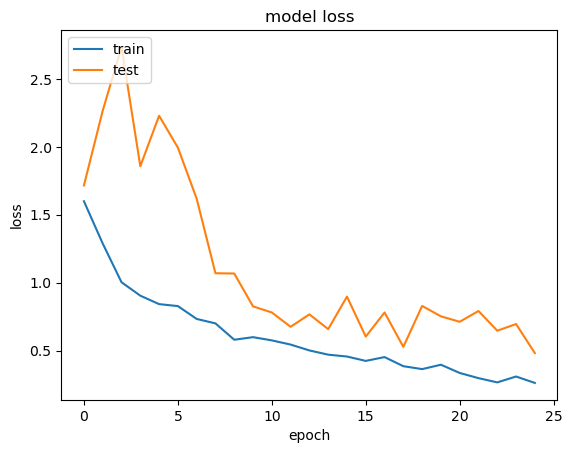

In [100]:
plot_loss_accuracy(history)

#### Conv 3D Model with 20 frames per video (32, 64, 128, 256) filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [101]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (32, 64, 128, 256)
dense_filters = (128, 128)
model = conv3D(conv_filters=conv_filters,dense_nodes=dense_filters, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 20


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 20, 120, 120, 32   2624      
                             )                                   
                                                                 
 activation_84 (Activation)  (None, 20, 120, 120, 32   0         
                             )                                   
                                                                 
 batch_normalization_73 (Ba  (None, 20, 120, 120, 32   128       
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_48 (MaxPooli  (None, 10, 60, 60, 32)    0         
 ng3D)                                                           
                                                                 
 conv3d_49 (Conv3D)          (None, 10, 60, 60, 64)  

In [102]:
callbacks_list = model_callbacks("model_conv3D_8")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=False, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [103]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
64/67 [===========================>..] - ETA: 13s - loss: 1.6516 - categorical_accuracy: 0.3984

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.6404 - categorical_accuracy: 0.4027
Epoch 1: val_loss improved from inf to 1.67882, saving model to model_conv3D_8_2023-12-1221_57_21.433890/model-00001-1.64035-0.40271-1.67882-0.23000.h5
67/67 [==============================] - 304s 5s/step - loss: 1.6404 - categorical_accuracy: 0.4027 - val_loss: 1.6788 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.1994 - categorical_accuracy: 0.5219
Epoch 2: val_loss did not improve from 1.67882
67/67 [==============================] - 304s 5s/step - loss: 1.1994 - categorical_accuracy: 0.5219 - val_loss: 2.9906 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 1.1445 - categorical_accuracy: 0.5400
Epoch 3: val_loss did not improve from 1.67882
67/67 [==============================] - 300s 4s/step - loss: 1.1445 - categorical_accuracy: 0.5400 - val_loss: 2

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


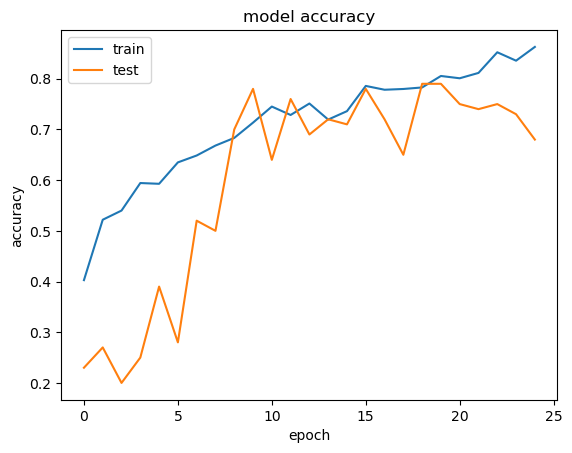

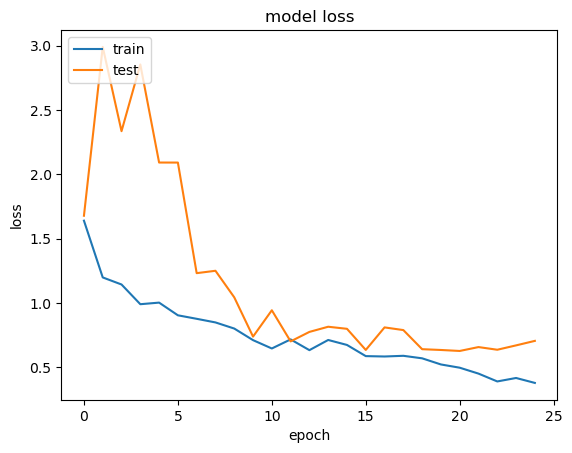

In [104]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video and a 5 by 5 filter size (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [105]:
#write your model here
def conv3D_5by5(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (5, 5, 5), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

In [106]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D_5by5(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 30, 120, 120, 16   6016      
                             )                                   
                                                                 
 activation_91 (Activation)  (None, 30, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_79 (Ba  (None, 30, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_52 (MaxPooli  (None, 15, 60, 60, 16)    0         
 ng3D)                                                           
                                                           

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [107]:
callbacks_list = model_callbacks("model_conv3D_9")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [108]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
64/67 [===========================>..] - ETA: 26s - loss: 1.6750 - categorical_accuracy: 0.4000

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.6856 - categorical_accuracy: 0.3922
Epoch 1: val_loss improved from inf to 4.93453, saving model to model_conv3D_9_2023-12-1221_57_21.433890/model-00001-1.68562-0.39216-4.93453-0.27000.h5
67/67 [==============================] - 604s 9s/step - loss: 1.6856 - categorical_accuracy: 0.3922 - val_loss: 4.9345 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.3644 - categorical_accuracy: 0.4781
Epoch 2: val_loss did not improve from 4.93453
67/67 [==============================] - 455s 7s/step - loss: 1.3644 - categorical_accuracy: 0.4781 - val_loss: 5.3025 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.3092 - categorical_accuracy: 0.4887
Epoch 3: val_loss improved from 4.93453 to 4.42150, saving model to model_conv3D_9_2023-12-1221_57_21.433890/model-00003-1.30924-0.48869-4.42150-0.31000.h5
67/6

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


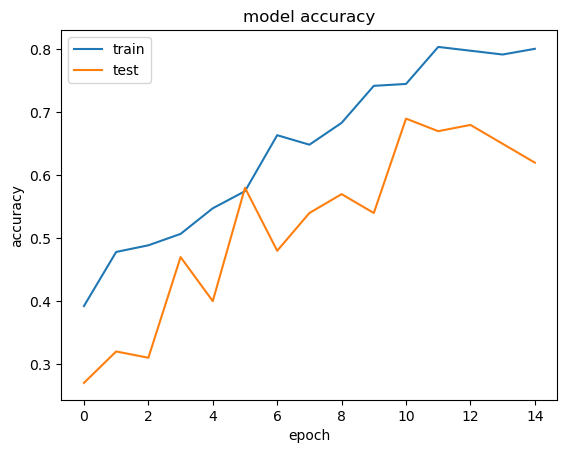

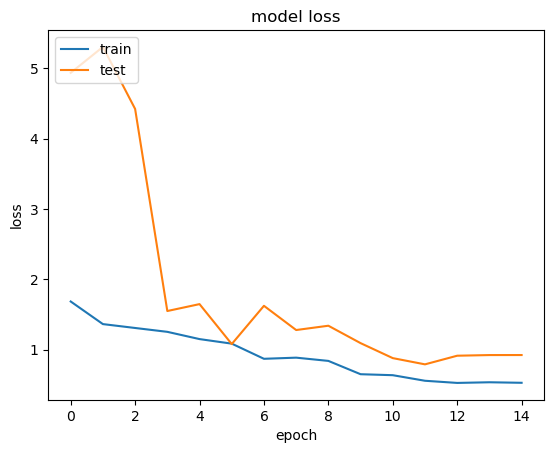

In [109]:
plot_loss_accuracy(history)

### TRANSFER LEARNING - MobileNet Conv2d + GRU

In [110]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

#### Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes

In [111]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20


Number of layers in the pretrained mobilenet model:  86


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDi  (None, 20, 3, 3, 1024)    3228864   
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 20, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_6 (TimeDi  (None, 20, 1, 1, 1024)    0         
 stributed)                                                      
                                                                 
 time_distributed_7 (TimeDi  (None, 20, 1024)          0         
 stributed)                                                      
                                                                 
 gru_1 (GRU)                 (None, 128)             

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [112]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [113]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
64/67 [===========================>..] - ETA: 7s - loss: 1.2658 - categorical_accuracy: 0.4953

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.2545 - categorical_accuracy: 0.5023
Epoch 1: val_loss improved from inf to 1.00282, saving model to model_retrain_mobilenet_gru_2023-12-1221_57_21.433890/model-00001-1.25449-0.50226-1.00282-0.57000.h5
67/67 [==============================] - 175s 3s/step - loss: 1.2545 - categorical_accuracy: 0.5023 - val_loss: 1.0028 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6287 - categorical_accuracy: 0.7768
Epoch 2: val_loss did not improve from 1.00282
67/67 [==============================] - 169s 3s/step - loss: 0.6287 - categorical_accuracy: 0.7768 - val_loss: 1.0036 - val_categorical_accuracy: 0.6600 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3391 - categorical_accuracy: 0.8643
Epoch 3: val_loss improved from 1.00282 to 0.21637, saving model to model_retrain_mobilenet_gru_2023-12-1221_57_21.433890/model-00003-0.33909-0.864

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


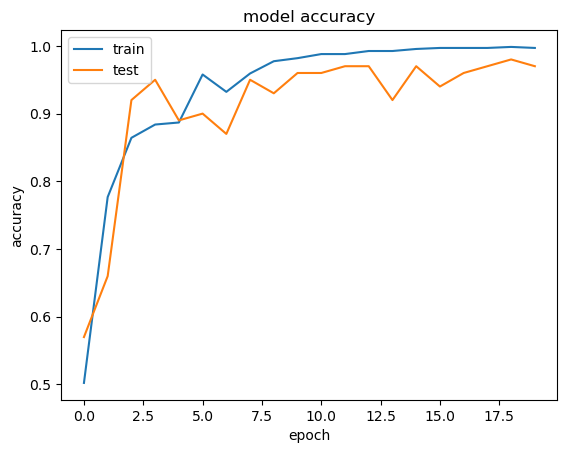

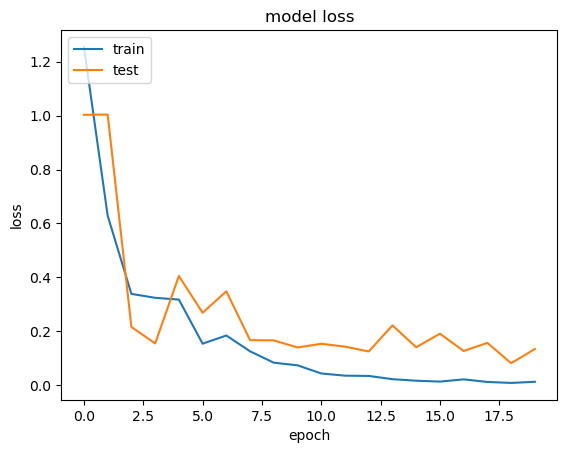

In [114]:
plot_loss_accuracy(history)

#### Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [115]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(gru=True, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 30


Number of layers in the pretrained mobilenet model:  86


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_8 (TimeDi  (None, 30, 3, 3, 1024)    3228864   
 stributed)                                                      
                                                                 
 time_distributed_9 (TimeDi  (None, 30, 3, 3, 1024)    4096      
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 30, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 30, 1024)          0         
 istributed)                                                     
                                                                 
 gru_2 (GRU)                 (None, 128)             

In [116]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [117]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
64/67 [===========================>..] - ETA: 16s - loss: 1.2431 - categorical_accuracy: 0.4859

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.2330 - categorical_accuracy: 0.4887
Epoch 1: val_loss improved from inf to 1.24574, saving model to model_retrain_mobilenet_gru_2023-12-1221_57_21.433890/model-00001-1.23301-0.48869-1.24574-0.44000.h5
67/67 [==============================] - 375s 6s/step - loss: 1.2330 - categorical_accuracy: 0.4887 - val_loss: 1.2457 - val_categorical_accuracy: 0.4400 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.5948 - categorical_accuracy: 0.7888
Epoch 2: val_loss improved from 1.24574 to 0.42010, saving model to model_retrain_mobilenet_gru_2023-12-1221_57_21.433890/model-00002-0.59479-0.78884-0.42010-0.87000.h5
67/67 [==============================] - 344s 5s/step - loss: 0.5948 - categorical_accuracy: 0.7888 - val_loss: 0.4201 - val_categorical_accuracy: 0.8700 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3462 - categorical_accuracy: 0.8854
Epoch 3: val_loss improve

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


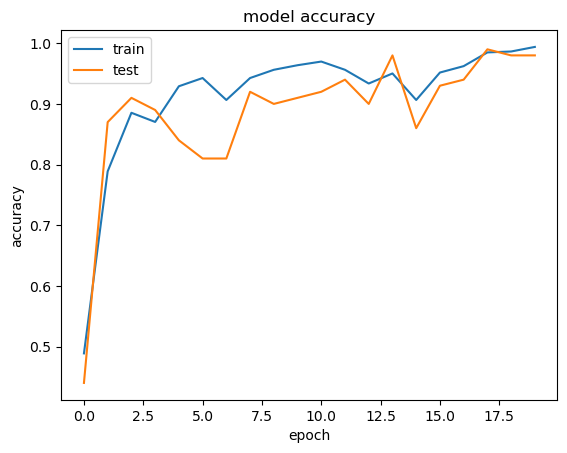

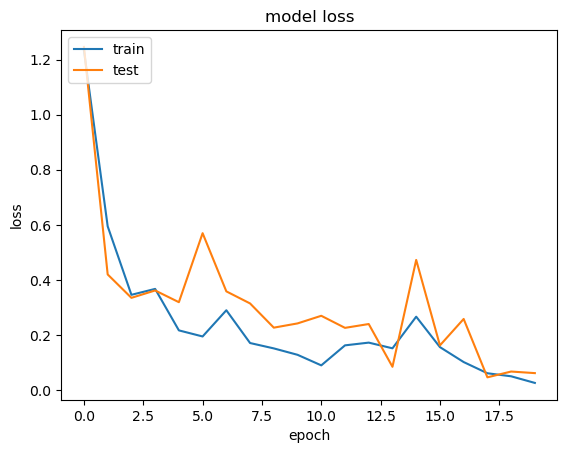

In [118]:
plot_loss_accuracy(history)

#### Mobilenet (fine tune) + GRU (128 cells) + 128 dense nodes

In [119]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=True, gru=True, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20


Number of layers in the pretrained mobilenet model:  86


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeD  (None, 20, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, 20, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 20, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_15 (TimeD  (None, 20, 1024)          0         
 istributed)                                                     
                                                                 
 gru_3 (GRU)                 (None, 128)             

In [120]:
callbacks_list = model_callbacks("model_finetune_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [121]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 2s - loss: 1.1771 - categorical_accuracy: 0.4908

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.1784 - categorical_accuracy: 0.4917
Epoch 1: val_loss improved from inf to 0.84398, saving model to model_finetune_mobilenet_gru_2023-12-1221_57_21.433890/model-00001-1.17836-0.49170-0.84398-0.67000.h5
67/67 [==============================] - 91s 1s/step - loss: 1.1784 - categorical_accuracy: 0.4917 - val_loss: 0.8440 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6223 - categorical_accuracy: 0.7632
Epoch 2: val_loss improved from 0.84398 to 0.37314, saving model to model_finetune_mobilenet_gru_2023-12-1221_57_21.433890/model-00002-0.62228-0.76320-0.37314-0.84000.h5
67/67 [==============================] - 91s 1s/step - loss: 0.6223 - categorical_accuracy: 0.7632 - val_loss: 0.3731 - val_categorical_accuracy: 0.8400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3133 - categorical_accuracy: 0.8974
Epoch 3: val_loss did not

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


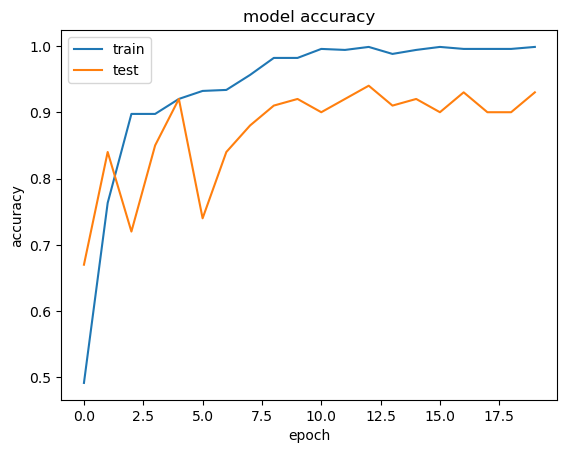

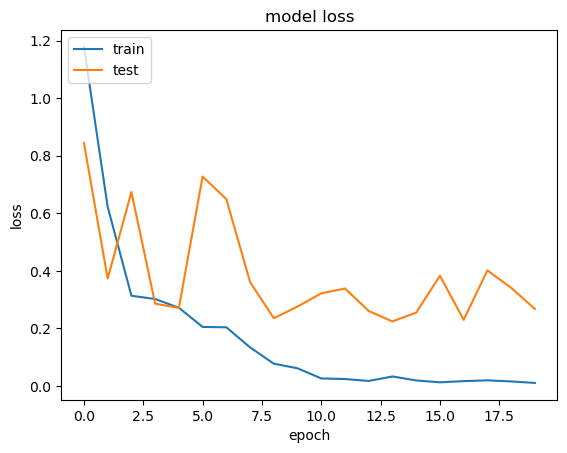

In [122]:
plot_loss_accuracy(history)

#### Mobilenet (re train all wieghts) + LSTM (128 cells) + 128 dense nodes




In [123]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20


Number of layers in the pretrained mobilenet model:  86


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeD  (None, 20, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, 20, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, 20, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, 20, 1024)          0         
 istributed)                                                     
                                                                 
 lstm (LSTM)                 (None, 128)             

In [124]:
callbacks_list = model_callbacks("model_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [125]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
64/67 [===========================>..] - ETA: 8s - loss: 1.3043 - categorical_accuracy: 0.4187 

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.2920 - categorical_accuracy: 0.4238
Epoch 1: val_loss improved from inf to 1.01579, saving model to model_retrain_mobilenet_lstm_2023-12-1221_57_21.433890/model-00001-1.29196-0.42383-1.01579-0.57000.h5
67/67 [==============================] - 192s 3s/step - loss: 1.2920 - categorical_accuracy: 0.4238 - val_loss: 1.0158 - val_categorical_accuracy: 0.5700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.8096 - categorical_accuracy: 0.7014
Epoch 2: val_loss improved from 1.01579 to 0.72147, saving model to model_retrain_mobilenet_lstm_2023-12-1221_57_21.433890/model-00002-0.80959-0.70136-0.72147-0.69000.h5
67/67 [==============================] - 189s 3s/step - loss: 0.8096 - categorical_accuracy: 0.7014 - val_loss: 0.7215 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.5867 - categorical_accuracy: 0.7753
Epoch 3: val_loss did n

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


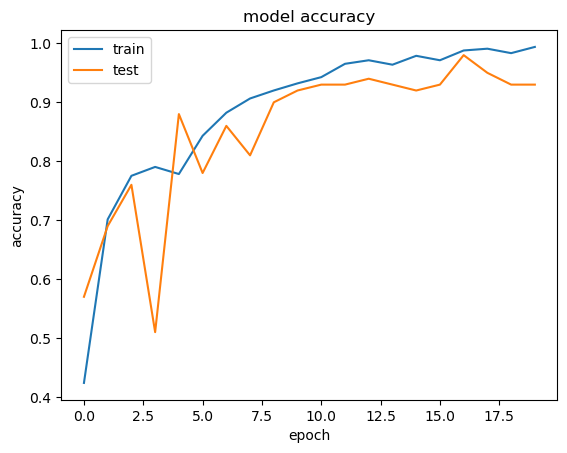

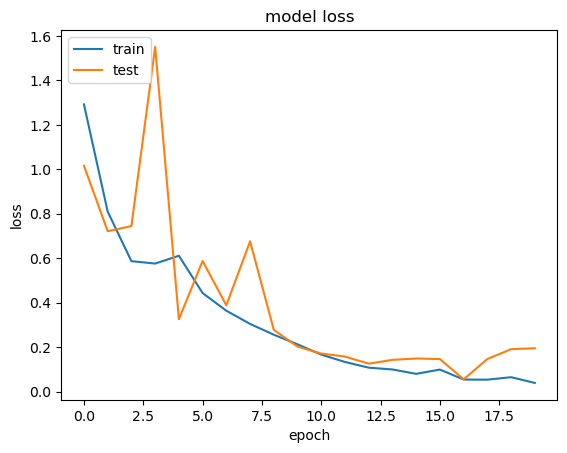

In [126]:
plot_loss_accuracy(history)

#### Mobilenet (re train all weights) + 64 dense nodes

In [127]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=True, num_images=num_frames, lstm_gru_cells=128, dense_nodes=64)
print(model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20


Number of layers in the pretrained mobilenet model:  86


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeD  (None, 20, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_21 (TimeD  (None, 20, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_22 (TimeD  (None, 20, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_23 (TimeD  (None, 20, 1024)          0         
 istributed)                                                     
                                                                 
 gru_4 (GRU)                 (None, 128)             

In [128]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru_64")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [129]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/4147385776.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
64/67 [===========================>..] - ETA: 8s - loss: 1.2158 - categorical_accuracy: 0.5156 

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.2042 - categorical_accuracy: 0.5189
Epoch 1: val_loss improved from inf to 1.06048, saving model to model_retrain_mobilenet_gru_64_2023-12-1221_57_21.433890/model-00001-1.20420-0.51885-1.06048-0.47000.h5
67/67 [==============================] - 212s 3s/step - loss: 1.2042 - categorical_accuracy: 0.5189 - val_loss: 1.0605 - val_categorical_accuracy: 0.4700 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.6247 - categorical_accuracy: 0.7707
Epoch 2: val_loss improved from 1.06048 to 0.80033, saving model to model_retrain_mobilenet_gru_64_2023-12-1221_57_21.433890/model-00002-0.62474-0.77074-0.80033-0.74000.h5
67/67 [==============================] - 213s 3s/step - loss: 0.6247 - categorical_accuracy: 0.7707 - val_loss: 0.8003 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.3813 - categorical_accuracy: 0.8627
Epoch 3: val_loss i

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


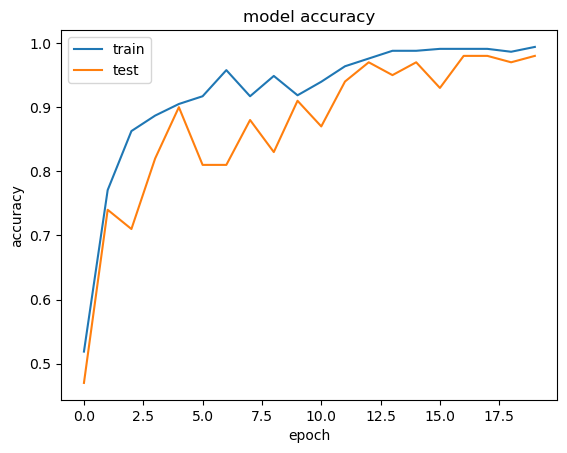

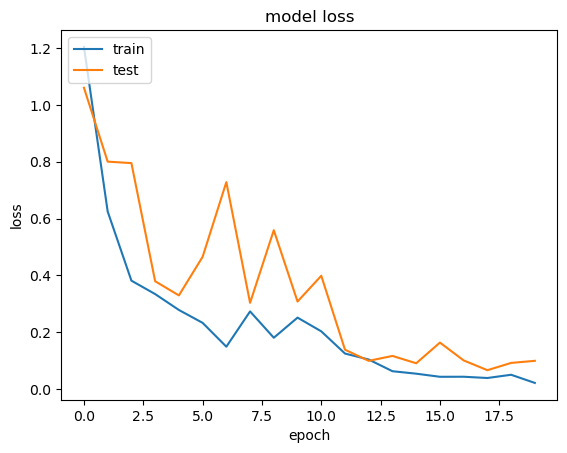

In [130]:
plot_loss_accuracy(history)

#### Mobilenet (re train all weights) + 64 dense nodes +  on training data set + Random data transformations

In [131]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames, lstm_gru_cells=128, dense_nodes=64)
print(model.summary())

# epochs = 25
# batch size = 10
# num frames per video = 20


Number of layers in the pretrained mobilenet model:  86


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeD  (None, 20, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_25 (TimeD  (None, 20, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_26 (TimeD  (None, 20, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_27 (TimeD  (None, 20, 1024)          0         
 istributed)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 128)             

In [132]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru_64")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [133]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator,
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/4147385776.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
64/67 [===========================>..] - ETA: 7s - loss: 1.2579 - categorical_accuracy: 0.4625 

/var/folders/6p/ld6lp0z95590ml0ydh3_l6k8ttdmtf/T/ipykernel_70742/3377856512.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.2442 - categorical_accuracy: 0.4706
Epoch 1: val_loss improved from inf to 1.21124, saving model to model_retrain_mobilenet_gru_64_2023-12-1221_57_21.433890/model-00001-1.24422-0.47059-1.21124-0.52000.h5
67/67 [==============================] - 185s 3s/step - loss: 1.2442 - categorical_accuracy: 0.4706 - val_loss: 1.2112 - val_categorical_accuracy: 0.5200 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 0.8017 - categorical_accuracy: 0.7014
Epoch 2: val_loss improved from 1.21124 to 0.79485, saving model to model_retrain_mobilenet_gru_64_2023-12-1221_57_21.433890/model-00002-0.80172-0.70136-0.79485-0.72000.h5
67/67 [==============================] - 180s 3s/step - loss: 0.8017 - categorical_accuracy: 0.7014 - val_loss: 0.7948 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.6702 - categorical_accuracy: 0.7632
Epoch 3: val_loss i

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


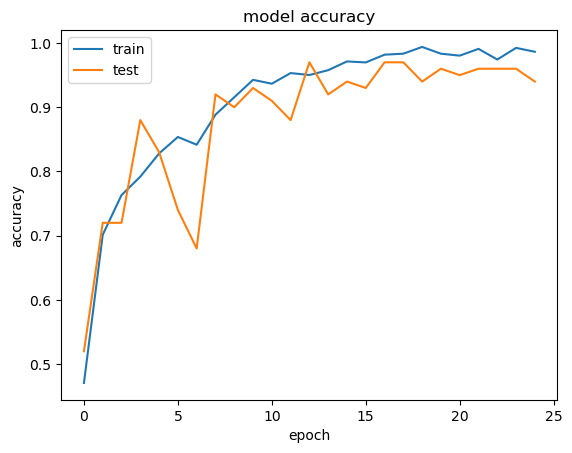

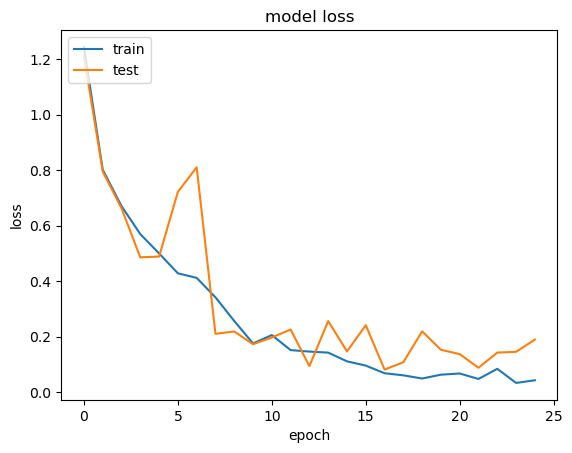

In [134]:
plot_loss_accuracy(history)